In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sklearn.set_config(display=”diagram”)

<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>
<font color='red' size=5>
    The show so far ... 
</font>


**Summary**

1. Load data
2. Remove features
    * features missing more than 10%
    * features with high correlations to the other features
        * used hierarchical correlation dropper
3. Stage 1 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Scale num. features
        * perhaps better to wait until after 
            1. cat. encoding is done with ordinals
            2. imputation for (all) features
    * Cat. features
        * used Ordinal and OneHot-encoders
        * used custom encoder to include NANs
    * Retrieve column names        
    * Recast all features as needed
4. Stage 2 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Impute remaining features
        * Used `SimpleImputer`
        * `KNNImputer` failed
    * Retrieve column names
    * Recast all features as needed

5. Modeling

6. Evaluate errors

7. Feature importance

**TODOs**

0. Priorities
   1. $\checkmark$ ~~Remove the target feature for the pipeline?~~
        * if the pipeline is fit for the independent features, then it should work with them alone;
        * whatever preprocessing is needed for the target feature can be done independently, outside of the pipeline 
   
1. $\checkmark$ ~~Get the columns names of the transformed data after the `Pipeline` / `ColumnTransformer` steps~~
    * _Needed for checking, further exploration, and featuring engineering_
    
2. Check on the appropriate strategies
    * $\checkmark$ ~~first do cat. encoding with `ColumnTransformer`, then do scaling on numericals in another `Pipeline`~~
    * ~~do everything in a single `Pipeline` taking care of the steps~~ $\to$ everything done with `ColumnTransformer` instead
        * allows individual selection of features for transformations
    * ~~Drop features with many unfilled values (can't do _after_ imputing) or just impute?, then pipeline~~ 
        * $\checkmark$ ~~Drop features with many unfilled values before/after preprocessing?~~
        * $\checkmark$ ~~impute afterwards~~

3. $\checkmark$ ~~Drop features which are mutually correlated; keep only the most relevant ones~~
    * **!!!** do this before first preprocessing stage?

4. More EDA
    * Identify quantities to be removed:
        * $\checkmark$ ~~IDs which contribute to the spikes in the neg. tail of the 'price_doc' distribution~~ $\to$ _this led to a big step in improvement_
            * ~~or see if they're correlated with another feature, like 'sub_area'~~ $\to$ did not find this; just removed sampled IDs
            * **open** 
                * is it possible to automatically detect narrow-bin spikes in a distribution? and eleminate the rows which contribute to them?
        * $\checkmark$ ~~check the distribution of the 'sub_area' feature~~
            * ~~are there enough samples for each category?~~ 

5. More feature engineering
    * There are a few more things which can be done to see if there's an improvement:
        * $\checkmark$ ~~removing some IDs (rows) which have some outlier behavior (clearly defined spikes in distributions)~~
        * aggregating some features together (e.g. combining nearby 'sub_areas') $\to$ needs some ad hoc investigations
        * $\checkmark$ Using the classifiers to identify and reduce the number of features to only the important ones. $\to$ _no improvement; slightly worse with XGB_
            * $\checkmark$ removed the 'sub_area' feature entirely $\to$ _no improvement_
            * **TODO** try with other classifiers

6. Try to package up the routine into a single stage with a multistep pipeline
    * The issue is employing the KNN_imputer
        * the issue _was_ keeping track of the columns since the stages work on different subsets;
    * An idea would be to
        1. Order the columns first by datatype
        2. Then do the structure-preserving transformations (transformations which preserve the number of columns) like scaling, ordinal encoding, imputing(?))
        3. Then do the transformations like OneHotEnc 
    * **Notes**
        * since ther original plan was to use the KNN-imputer, where all features were needed together, this meant
            1. process the num. and cat. features separately
            2. re-attach columns and re-cast dtypes
            3. apply the KNN-imputer
    * **IDEA** to generalize, need a flexible pipeline 
        * `overall_pipeline([sub_pipeline1(data_subsetA, data_subsetB, data_subsetC), sub_pipeline2(data_subsetA, data_subset_rest),...])`
        * the problem is keeping track of the columns since after the first subpipeline, they will be lost.
            
**Notes**
* All transforms were included with `ColumnTransformer`
    * selects cols individually
    * can act as a pipeline
    * retrieve the columns names and ordering
        * _this is important to do the next steps of processing_

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import os

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [6]:
#import importlib
import sys
sys.path.append('./helpers/')

## Load the data

In [7]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [8]:
df.shape

(30471, 292)

Get the dtypes of the DF; save to a dict for later use

In [9]:
df_dtypes = df.dtypes.reset_index().rename(columns={'index':'column', 0:'datatype'})
df_dtype_dict = dict(zip(df_dtypes.column, df_dtypes.datatype.astype(str)))

## Preprocess the data

### Feature work: the target

#### Separate the target feature

**Note** the target feature may also need to be transformed, _e.g._ rescaled

In [10]:
target_feature = 'price_doc'
target_col = [target_feature]

In [11]:
df[target_col].head()

,price_doc
0,5850000
1,6000000
2,5700000
3,13100000
4,16331452


In [12]:
df_targ = df[['id']+target_col].copy()

In [13]:
df = df.drop(columns=target_feature)

In [14]:
#feature_importance_dropped_cols = ['incineration_raion', 'big_market_raion', 'sub_area']
#df = df.drop(columns=feature_importance_dropped_cols)

#### Inspect and clean the target

In [15]:
df_targ['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

In [16]:
targ_vals = df_targ['price_doc'].values

In [17]:
bin_width = 1e5
bins=np.arange(bin_width, 1.2e8 + bin_width, bin_width)

In [18]:
peaks = np.arange(1,20.5,0.5)*1e6 

In [19]:
from distribution_tools import get_smooth_ids

In [20]:
id_list = get_smooth_ids(df_targ, 'id', 'price_doc', peaks, bin_width, False) 

In [21]:
hist_df_price_doc, _ = np.histogram(targ_vals, bins=bins, density=False)

In [22]:
hist_df_price_doc_, _ = np.histogram(df_targ[df_targ['id'].isin(id_list)].price_doc.values, bins=bins, density=False)

In [23]:
bars = False

In [24]:
from matplotlib.ticker import MultipleLocator

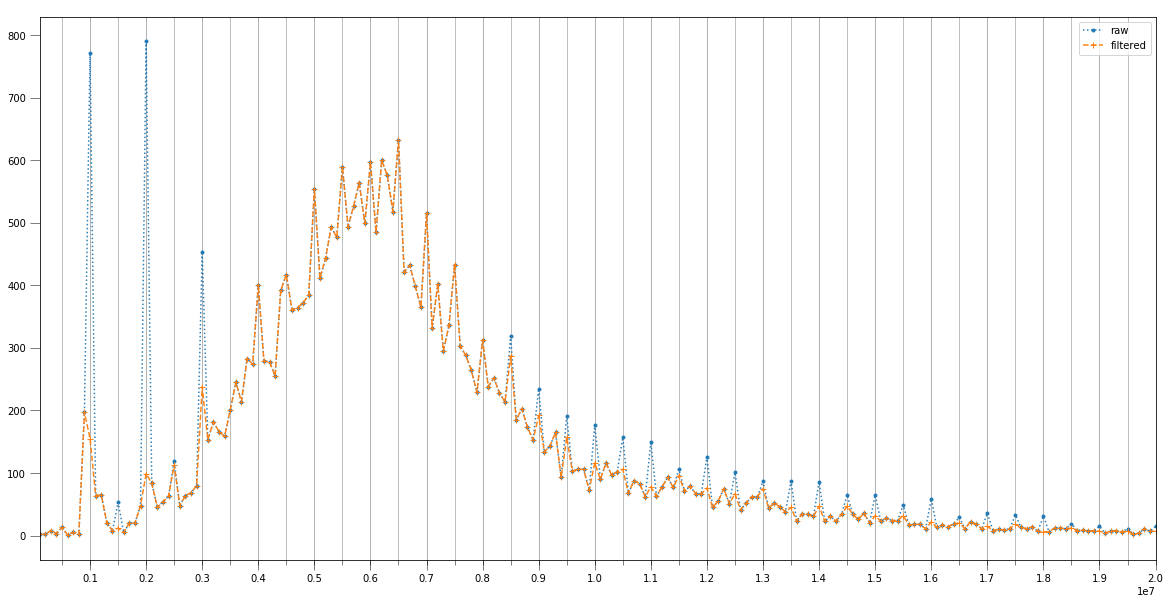

In [25]:
fig, ax = plt.subplots(1,1,figsize=[20,10])

norma = 1.0 #30471.0

if bars:
    ax.bar( x=bins[:-1],height=hist_df_price_doc /norma, width=bin_width, label='raw', alpha=0.35)
    ax.bar( x=bins[:-1],height=hist_df_price_doc_/norma, width=bin_width/2, align='edge', label='filtered', alpha=0.95)
else:
    ax.plot(bins[:-1],hist_df_price_doc /norma, '.:', label='raw', alpha=0.95)
    ax.plot(bins[:-1],hist_df_price_doc_/norma, '+--', label='filtered', alpha=0.95)

ax.set_xlim(1e5, 2e7)

ax.legend()

ax.xaxis.set_major_locator(MultipleLocator(1e6))
ax.xaxis.set_minor_locator(MultipleLocator(5e5))

ax.tick_params(which='both', width=0.5)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5)

ax.grid(which='both',axis='x');

**Notes** there are spikes in price values for every interval of 500k CURRENCY; some are reasonable, but mostly they appear distinct. 
Such spikes could be due to some mechanism which (due to their lack of counts) would not be picked up in a model.

#### filter the smoothed IDs

In [26]:
id_list = list(map(int, id_list))
df_targ = df_targ[df_targ['id'].isin(id_list)].copy()
df = df[df['id'].isin(id_list)].copy()

### Feature work: the rest

#### Separate some features based on type and/or use

##### Identify the numerical features

In [27]:
ignore_cols = ['id','timestamp']

In [28]:
float_cols = df.drop(columns=ignore_cols).select_dtypes('float').columns.tolist()

int_cols = df.drop(columns=ignore_cols).select_dtypes('int').columns.tolist()

num_cols = df.drop(columns=ignore_cols).select_dtypes(['int', 'float']).columns.tolist()

Select the categorical features

In [29]:
string_cols = df.drop(columns=ignore_cols).select_dtypes('object').columns.tolist()

### Drop features

#### Characterize the missing values

In [30]:
from helpers.fill_rates import get_column_fill_rates, get_row_fill_rates

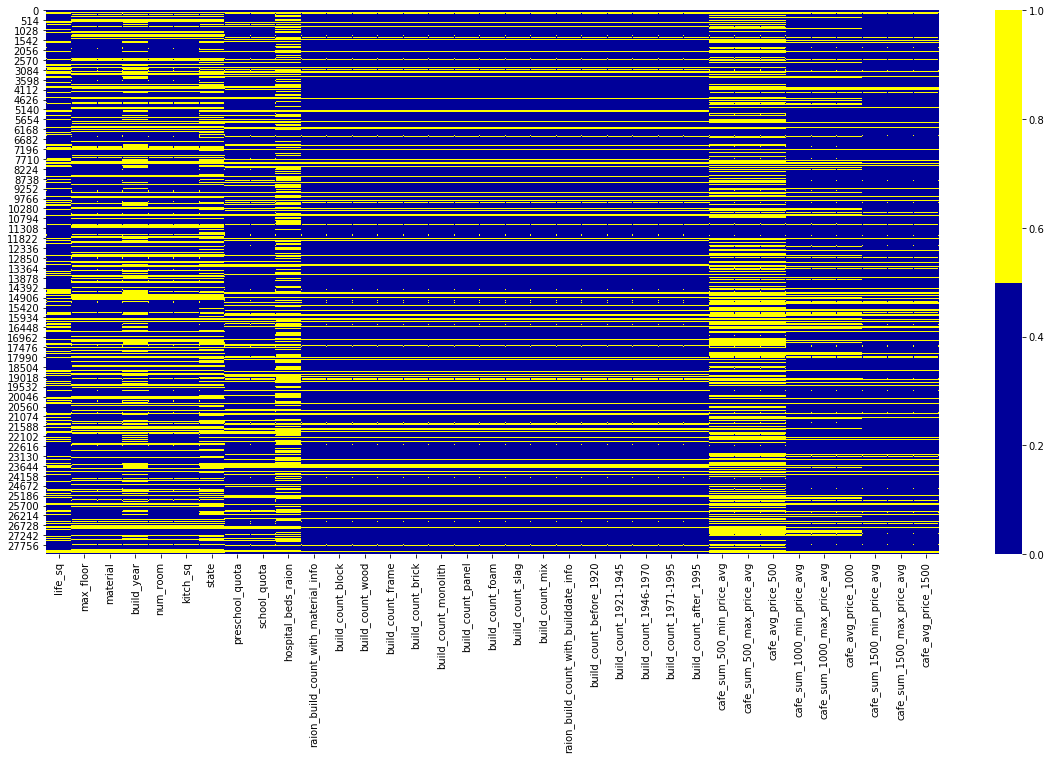

In [31]:
df_fillrates = get_column_fill_rates(df,0.0)
unfilled_cols = df_fillrates[df_fillrates['frac_full']<=0.90]['column_name'].tolist()

plt.figure(figsize=[20,10])
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[unfilled_cols].isnull().sample(frac=1).reset_index(drop=True), cmap=sns.color_palette(colours))

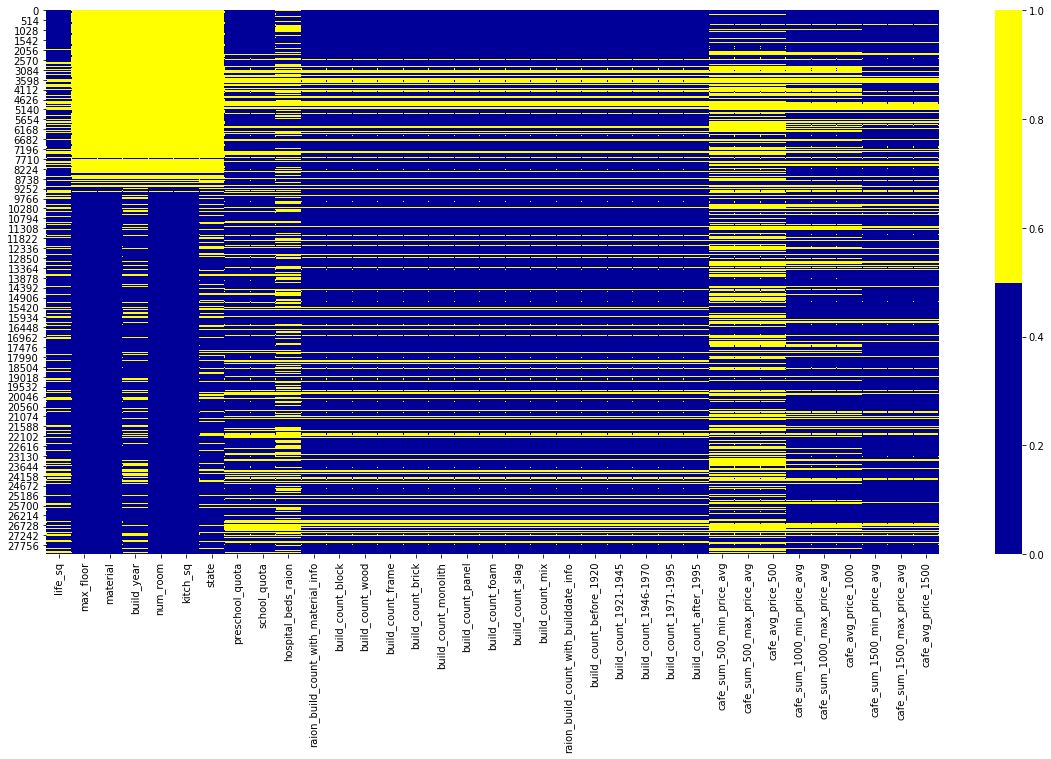

In [32]:
plt.figure(figsize=[20,10])
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[unfilled_cols].isnull().reset_index(drop=True), cmap=sns.color_palette(colours))

##### Check the fill rate of the features

Keep all features having more than 90% (arbitrary) of their values

In [33]:
threshold = 0.90
df_fillrates = get_column_fill_rates(df,threshold)
display(df_fillrates.sort_values("frac_full", ascending=True)[:10])

,column_name,frac_full
229,cafe_sum_2000_min_price_avg,0.939400
230,cafe_sum_2000_max_price_avg,0.939400
231,cafe_avg_price_2000,0.939400
252,cafe_sum_3000_min_price_avg,0.965341
254,cafe_avg_price_3000,0.965341
253,cafe_sum_3000_max_price_avg,0.965341
275,cafe_sum_5000_min_price_avg,0.989829
276,cafe_sum_5000_max_price_avg,0.989829
277,cafe_avg_price_5000,0.989829
269,prom_part_5000,0.993763


In [34]:
filled_cols = df_fillrates.column_name.tolist()
print(f'Number of features more than {round(100*threshold)}% filled: { len(filled_cols)}')

Number of features more than 90% filled: 256


##### Check the fill rate of the rows

**Note** this is passive; nothing is done with this info; it will also change when the unfilled features are removed

<font color='red' size=2>
    If this were applied, then the target_feature would need to be included (or matched by keeping the `id`)
</font>

In [35]:
threshold = 0.85
df_fillrates = get_row_fill_rates(df,threshold)
display(df_fillrates.sort_values("frac_full", ascending=True)[:10])

,id,row_counts,frac_full
23915,25827,250,0.859107
7987,8575,250,0.859107
22585,24390,250,0.859107
9390,10095,250,0.859107
23245,25102,250,0.859107
4276,4683,250,0.859107
20864,22528,250,0.859107
8565,9203,250,0.859107
6973,7528,250,0.859107
27548,29757,250,0.859107


In [36]:
print(f'Number of features more than {round(100*threshold)}% filled: { df_fillrates.shape[0]}')

Number of features more than 85% filled: 28217


##### Check the information content of the features

If the features contain little useful information (_ie_ they have low variance), they might not contribute much to the model. 
<br/>
For efficiecy reasons, it might be best to drop these, though the resulting model will likely be unchanged.

In [37]:
num_rows = len(df.index)
low_information_cols = [] #

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

oil_chemistry_raion: 99.04316%
no     27948
yes      270
Name: oil_chemistry_raion, dtype: int64

railroad_terminal_raion: 96.22936%
no     27154
yes     1064
Name: railroad_terminal_raion, dtype: int64

nuclear_reactor_raion: 97.32086%
no     27462
yes      756
Name: nuclear_reactor_raion, dtype: int64

big_road1_1line: 97.49805%
no     27512
yes      706
Name: big_road1_1line, dtype: int64

railroad_1line: 97.01609%
no     27376
yes      842
Name: railroad_1line, dtype: int64

cafe_count_500_price_high: 97.18265%
0    27423
1      751
2       34
3       10
Name: cafe_count_500_price_high, dtype: int64

mosque_count_500: 99.54284%
0    28089
1      129
Name: mosque_count_500, dtype: int64

leisure_count_500: 95.04926%
0    26821
1     1159
2      118
4       50
3       44
9        8
5        7
7        6
6        4
8        1
Name: leisure_count_500, dtype: int64

cafe_count_1000_price_high: 95.53122%
0    26957
1     1031
2      129
3       47
4       33
5       12
6        8
7      

In [38]:
len(low_information_cols)

11

##### Dropping rows of cat. features with low representation

Consider dropping rows which contribute to the tail-end of features' distributions

(_Ideally, they would be outliers in several features, but this is difficult to check with no promise of a significant reward_)

In [39]:
num_rows = len(df.index)
low_rep_cat_cols = [] #

col = 'sub_area'
cnts = df[col].value_counts(dropna=False)
top_pct = (cnts/num_rows).iloc[0]

low_rep_cat_cols.append(col)
print('{0}: {1:.5f}%'.format(col, top_pct*100))
df_cnts = cnts.reset_index().rename(columns={'index':'sub_area', 'sub_area':'counts'})

sub_area: 6.27614%


In [40]:
df_cnts['%'] = df_cnts.counts.apply(lambda x: round(100.*x/num_rows,2))
df_cnts = df_cnts.sort_values('counts',ascending=False)

In [41]:
df_cnts.head(20)

,sub_area,counts,%
0,Poselenie Sosenskoe,1771,6.28
1,Nekrasovka,1599,5.67
2,Poselenie Vnukovskoe,1371,4.86
3,Poselenie Moskovskij,921,3.26
4,Poselenie Voskresenskoe,712,2.52
5,Tverskoe,666,2.36
6,Mitino,655,2.32
7,Poselenie Filimonkovskoe,496,1.76
8,Krjukovo,489,1.73
9,Mar'ino,460,1.63


In [42]:
csum = np.cumsum(df_cnts['%'].values)

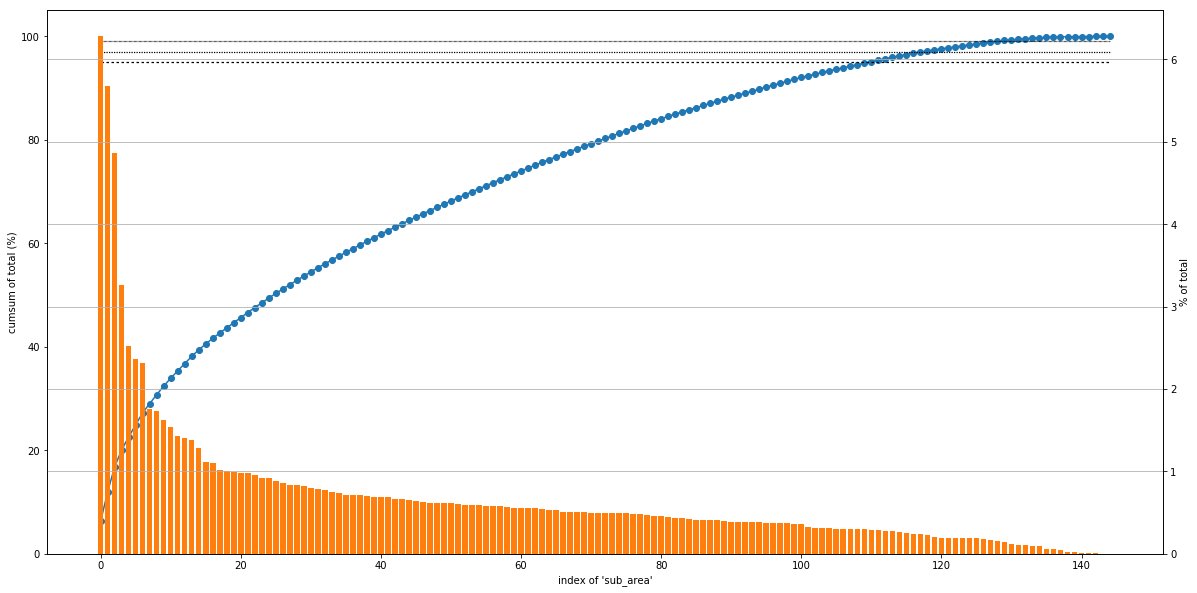

In [43]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
ax.plot(csum,'o-')
ax.plot([0,144],[99,99],'k--', dashes=[0.5,0.5], linewidth=1.25)
ax.plot([0,144],[97,97],'k--', dashes=[1.0,1.0], linewidth=1.25)
ax.plot([0,144],[95,95],'k--', dashes=[2.0,2.0], linewidth=1.25)
ax.set_ylabel('cumsum of total (%)')
ax.set_ylim(0,105)
ax1=ax.twinx()
ax1.bar(x=df_cnts.index, height=df_cnts['%'].values, color='C1')
ax1.set_ylabel('% of total')
ax1.grid()
ax.set_xlabel('index of \'sub_area\'');

In [44]:
cats_to_exclude = []
counts = 0
for n,r in df_cnts.sort_values('counts').iterrows():

    if counts/num_rows > 0.01:
        print(counts, counts/num_rows)
        break
    counts += r['counts']
    cats_to_exclude.append(r['sub_area'])

312 0.011056772273017223


In [45]:
print(len(cats_to_exclude))
print(cats_to_exclude)

17
['Poselenie Mihajlovo-Jarcevskoe', 'Poselenie Shhapovskoe', 'Poselenie Kievskij', 'Molzhaninovskoe', 'Poselenie Marushkinskoe', 'Poselenie Voronovskoe', 'Vostochnoe', 'Arbat', 'Poselenie Mosrentgen', 'Poselenie Kokoshkino', 'Poselenie Krasnopahorskoe', "Krasnosel'skoe", 'Severnoe', 'Poselenie Rogovskoe', 'Poselenie Rjazanovskoe', 'Vnukovo', "Zamoskvorech'e"]


In [46]:
df_cnts[df_cnts['sub_area'].isin(cats_to_exclude)]

,sub_area,counts,%
128,Zamoskvorech'e,46,0.16
129,Vnukovo,43,0.15
130,Poselenie Rjazanovskoe,34,0.12
131,Poselenie Rogovskoe,31,0.11
132,Severnoe,31,0.11
133,Krasnosel'skoe,29,0.10
134,Poselenie Krasnopahorskoe,25,0.09
135,Poselenie Kokoshkino,18,0.06
136,Poselenie Mosrentgen,16,0.06
137,Arbat,14,0.05


**Notes** 

Strategies:
* drop the rows with these values $\to$ _means no prediction will be made for these!!!_
* combine these values into a new value, e.g. `'other'`
* (advanced) combine nearby regions of low counts into neighbors with higher counts

<font color='red' size=3>
    Warning: as above, if this were applied, then the target_feature would need to be included (or matched by keeping the `id`)
</font>

#### Correlation-based feature drop

In [47]:
from helpers.correlation_feature_drop import get_dropped_columns

In [48]:
threshold = 0.9

In [49]:
# Note: be sure to include the target feature in the correlation --> the current function requires it.
df_corr = df.drop(columns=ignore_cols+string_cols)
df_corr[target_feature] = df_targ['price_doc']
df_corr = df_corr.corr().abs()

In [50]:
drop_corr_cols = get_dropped_columns(df_corr, target_feature, threshold, False)

Index(['col1', 'col2', 'corr'], dtype='object')
Index(['col1', 'col2', 'corr', 'self', 'price_doc'], dtype='object')


#### Select the cols to keep

In [51]:
keep_cols = [c for c in df.columns.tolist() if (c in filled_cols) & (c not in drop_corr_cols + low_information_cols)]

In [52]:
df = df[keep_cols]
print(df.shape) #(30471, 116)
#df = df[df['sub_area'].isin(cats_to_exclude)==False].copy()
print(df.shape)

(28218, 102)
(28218, 102)


### Transformations

#### Inspect the categorical then do encoding

**Note** need to regrab the new set of string cols since some were dropped.

In [53]:
string_cols = df.drop(columns=ignore_cols).select_dtypes('object').columns.tolist()

In [54]:
print(string_cols)

['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'radiation_raion', 'big_market_raion', 'detention_facility_raion', 'water_1line', 'ecology']


In [55]:
df[string_cols].head()

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,radiation_raion,big_market_raion,detention_facility_raion,water_1line,ecology
0,Investment,Bibirevo,no,no,no,no,no,no,no,good
1,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,excellent
2,Investment,Tekstil'shhiki,no,no,no,yes,no,no,no,poor
3,Investment,Mitino,no,no,no,no,no,no,no,good
4,Investment,Basmannoe,no,no,no,yes,no,no,no,excellent


**Note**
* Ordinals:
    * 'ecology'
* OneHots
    * 'sub_area', 'product_type' (but only two vals)
* Binaries
    * the rest
    * _But these will also be considered ordinals_

~~<font color='red' size=3>
    EDIT: dropped 'sub_area' functionality
</font>~~

In [56]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

import categorical_encoding
from categorical_encoding import OrdinalEncoderNans


onehot_cat_cols = ["sub_area", "product_type"]
#onehot_cat_cols = ["product_type"]

ord4_cat_cols = ["ecology"]
ord4_cats = ['poor', 'satisfactory', 'good', 'excellent', 'no data'] # Normally, this is a nested list, ie [[1,2,3,...]]

ord2_cat_cols = [e for e in string_cols if (e not in onehot_cat_cols) & (e not in ord4_cat_cols) ]
ord2_cats = len(ord2_cat_cols)*[["no", "yes"]]

In [57]:
df[onehot_cat_cols].nunique()

sub_area        145
product_type      2
dtype: int64

In [58]:
onehot_sum = sum(df[onehot_cat_cols].nunique())

print(len(num_cols), len(onehot_cat_cols), len(ord2_cat_cols), len(ord4_cat_cols))
sum([len(num_cols), onehot_sum, len(ord2_cat_cols), len(ord4_cat_cols)])

274 2 7 1


429

#### Pipelines

##### Numerical features in a pipeline

**Note** could also use with the ColumnTransformer, like the cat. features, since is only one transform on the subset

In [59]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
# Use in ColumnTransformer as 
#   ("num_pipe",  num_pipeline, num_cols),


##### putting the cat-encs together into the pipeline

In [60]:
# Need to re-grab the numerics as well!
num_cols = df.drop(columns=ignore_cols).select_dtypes(['int', 'float']).columns.tolist()

In [61]:
pipeline_stage1 = ColumnTransformer([    
        ("ignored",   FunctionTransformer(lambda x: x), ignore_cols),
        #("target",  StandardScaler(), target_col),  
        ("num_cols",  StandardScaler(), num_cols),  
        ("onehots",   OneHotEncoder(sparse=False), onehot_cat_cols),
        ("ordinals2", OrdinalEncoder(ord2_cats), ord2_cat_cols),   
        ("ordinals4", OrdinalEncoderNans(ord4_cats), ord4_cat_cols),    
    ])

data = pipeline_stage1.fit_transform(df)

In [62]:
data.shape

(28218, 247)

In [63]:
df.shape

(28218, 102)

####  Retrieve the column names

This is a bit specific here, but generalizable

In [64]:
def get_transformed_column_names(pipeline_transformers):

    prepro_columns = []
    for line in pipeline_stage1.transformers_[:]:

        #print(type(line[1]).__name__ )
        if type(line[1]).__name__ == 'OneHotEncoder':
            # Note: can include old column identifiers in the OHE feature names
            #    with .get_feature_names(ohe_column_names)
            new_cols = line[1].get_feature_names().tolist()
            #print(line[0],'\t', len(new_cols))
            prepro_columns += new_cols
        else:
            new_cols = line[2]
            #print(line[0],'\t', len(new_cols))
            prepro_columns += new_cols    
            
    return prepro_columns

In [65]:
prepro_columns = get_transformed_column_names(pipeline_stage1.transformers_)

In [66]:
onehot_sum = sum(df[onehot_cat_cols].nunique())
check_col_lengths = [len(ignore_cols), len(target_col), len(num_cols), onehot_sum, len(ord2_cat_cols), len(ord4_cat_cols)]
print(*check_col_lengths)
print(sum(check_col_lengths), '==', len(prepro_columns))

2 1 90 147 7 1
248 == 247


#### Rebuild the DF and re-cast the data type

Prepare for the next pipeline: imputing

##### Rebuild the DF

In [67]:
df = pd.DataFrame(data=data, columns=prepro_columns)

##### Re-cast the data types

In [68]:
ignored_dtypes = [df_dtype_dict[c] for c in ignore_cols]

def set_dtypes(prepro_columns, nonfloat_dtypes):
    """Set a new dtype dict for the preprocessed df
    
    Args:
      prepro_columns ([str]): columns for the dict keys
      nonfloat_dtypes ([str]): datatypes for the non-float datatypes 
                               (assumes these are in the front of prepro_columns)

    Returns:
      dict: dictionary of column to datatype
    """

    nr_float_cols = len(prepro_columns)-len(nonfloat_dtypes)

    #### NOTE: all preprocess cols will now be floats
    dtypes_list = nonfloat_dtypes + (nr_float_cols)*['float']

    return dict(zip(prepro_columns, dtypes_list))    

In [69]:
dtypes_dict = set_dtypes(prepro_columns, ignored_dtypes)

In [70]:
len(dtypes_dict)

247

In [71]:
df = df.astype(dtypes_dict)

In [72]:
df.head()

,id,timestamp,full_sq,floor,area_m,green_zone_part,indust_part,school_education_centers_raion,school_education_centers_top_20_raion,healthcare_centers_raion,...,x1_Investment,x1_OwnerOccupier,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,radiation_raion,big_market_raion,detention_facility_raion,water_1line,ecology
0,1,2011-08-20,-0.285700,-0.695798,-0.559651,-0.184606,-0.995065,0.112585,-0.325383,-0.190963,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,2,2011-08-23,-0.515834,-0.882375,-0.409257,0.852253,-0.576636,0.977443,-0.325383,-0.190963,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,3,2011-08-27,-0.285700,-1.068952,-0.635246,-0.622128,0.004995,0.689157,-0.325383,-0.190963,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,2011-09-01,0.890538,0.237088,-0.267729,-0.156395,-0.406823,1.554016,-0.325383,-0.190963,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,5,2011-09-05,0.583694,-0.695798,-0.465547,-1.173944,-0.680644,1.265729,-0.325383,1.826477,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0


## Second stage preprocessing

### Imputing

<font color='green' size=2> 
    Can this be organized with the above into a single pipeline?
    <br/>
    Possibly, since the following stage is an imputer
</font>

In [73]:
from sklearn.impute import SimpleImputer, KNNImputer

**Note** `KNNImputer` failed with a kernel restart. Memory? $\to$ try again

In [74]:
subprepro_columns = [c for c in prepro_columns if c not in ignore_cols + target_col]

In [75]:
pipeline_stage2 = ColumnTransformer([
        ("ignored",   FunctionTransformer(lambda x: x), ignore_cols),
        ('imputer', SimpleImputer(strategy='median'), subprepro_columns),    
    ])
 
####NOTE: still need to Scale the ordinalTransformed feature
data = pipeline_stage2.fit_transform(df)

### Rebuild the DF and re-cast the data type

In [76]:
#### NOTE: can use the same cols and dtypes as before since no further reordering of columns was made
df = pd.DataFrame(data=data, columns=prepro_columns).astype(dtypes_dict)

In [77]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28218 entries, 0 to 28217
Data columns (total 247 columns):
id                                       28218 non-null int64
timestamp                                28218 non-null datetime64[ns]
full_sq                                  28218 non-null float64
floor                                    28218 non-null float64
area_m                                   28218 non-null float64
green_zone_part                          28218 non-null float64
indust_part                              28218 non-null float64
school_education_centers_raion           28218 non-null float64
school_education_centers_top_20_raion    28218 non-null float64
healthcare_centers_raion                 28218 non-null float64
university_top_20_raion                  28218 non-null float64
sport_objects_raion                      28218 non-null float64
additional_education_raion               28218 non-null float64
shopping_centers_raion                   28218 non-nu

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 4.0px;"/>

# Modeling

In [78]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection, preprocessing

from sklearn.linear_model import LinearRegression

## Last transform to the target

In [79]:
stasca = StandardScaler()

In [80]:
df_targ['price_doc_'] = stasca.fit_transform(df_targ['price_doc'].values.reshape(-1, 1))

In [81]:
df_targ.head()

,id,price_doc,price_doc_
0,1,5850000,-0.306309
1,2,6000000,-0.274351
2,3,5700000,-0.338267
3,4,13100000,1.238313
4,5,16331452,1.926777


In [82]:
df_targ.shape

(28218, 3)

In [83]:
df_targ.head()

,id,price_doc,price_doc_
0,1,5850000,-0.306309
1,2,6000000,-0.274351
2,3,5700000,-0.338267
3,4,13100000,1.238313
4,5,16331452,1.926777


In [151]:
df.shape, df_targ.shape

((28218, 247), (28218, 3))

In [155]:
df_out = df.merge(df_targ, on=['id'], how='outer')

In [157]:
df_out.to_csv('../../datasets/sberbank-russian-housing-market/train_prepro.csv', index=False)

In [158]:
!ls -h -lat ../../datasets/sberbank-russian-housing-market/train_prepro.csv

-rw-r--r-- 1 sandm sandm 66M Mai 28 14:10 ../../datasets/sberbank-russian-housing-market/train_prepro.csv
